# RECESSION RISK PREDICTION - DAILY

Aiming to anticipate the next recession in the US economy, data from government bonds yield curve and investment-grade corporate bonds spread is used to approximate the recession risk probability introduced in 
[Recession Risk and the Excess Bond Premium](https://www.federalreserve.gov/econresdata/notes/feds-notes/2016/recession-risk-and-the-excess-bond-premium-20160408.html).

Click [here](https://www.federalreserve.gov/econresdata/notes/feds-notes/2016/files/ebp_csv.csv) to download the updated recession risk indicator.


## FEDS Method


### Corporate Bond Credit Spread

<p style="text-align: center;">
$S^{GZ}_t = \frac{1}{N} \Sigma_i \Sigma_k S_{i,t}[k]$
</p>

where $N_t$ denotes the number of bonds in month $t$ and $S_{i,t}[k]$ is the spread of bond $k$ (a security that is a liability of firm $i$) in month $y$

### Excess Bond Premium (EBP)

<p style="text-align: center;">
$EBP_t = S^{GZ}_t - \hat{S}^{GZ}_t$
<p style="text-align: center;">

Where $\hat{S}^{GZ}_t$ is the corporate bond spread after removing expected default risk of individual firms.

### Probability of Recession Risk

<p style="text-align: center;">
$ P({NBER}_{t, t+12} = 1) = \Phi( \alpha + \beta_1 S^{GS}_t + \gamma_1 TS_t + \gamma_2 RFF_t)$
</p>

Where $S^{GZ}_t$ is the GZ credit spread, $TS_t$ is the term spread and $RFF_t$ is the real funds rate.

Applying the EBP to the previous equation results in 

<p style="text-align: center;">
$ P({NBER}_{t, t+12} = 1) = \Phi( \alpha + \beta_1 \hat{S}^{GS}_t + \beta_2 EBP_t + \gamma_1 TS_t + \gamma_2 RFF_t)$
</p>

\** NBER = National Bureau of Economic Research 

## Proposed Method
The $GZ$ corporate bond spread is approximated as

<p style="text-align: center;">
$S^{GZ}_t \approx A^{GZ}_t + B^{GZ}_t$
</p>

Where $A^{GZ}_t$ is extracted from **CSI A Index** and $A^{GZ}_t$ from **CSI BBB Index**, both indices provided by Bloomberg.

The proposed model for probability of recession risk is presented as the following function

<p style="text-align: center;">
$ P({NBER}) = w_1 A^{GZ}_t + w_2 B^{GZ}_t + w_3 TS_t + w_1 RFF_t$
</p>

 
 

In [25]:
#Load packages
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import KFold

# FUNCTIONS AND PARAMETERS

# Plot parametes
xlim = ['2003', '2019']
ylim = [0, 1.1]
yticks = [0, 0.25, 0.50, 0.75, 1]
yticks_label = [str(int(i*100))+'%' for i in yticks]

# Dates
dates = ['2002-09', '2019-01']

# Normalize data
def scale(data):
    return (data - data.min()) * 1.0 / (data.max() - data.min())

# Plot recessions
def plot_recs(recs_d, ax, r=None, lim=0):
    for j in recs_d.index:
        start = mdates.date2num(recs_d.iloc[j, 1])
        end = mdates.date2num(recs_d.iloc[j, 2])
        rect = Rectangle((start, -1), end-start, 20, color='red', alpha=0.2)
        ax.add_patch(rect)   
        if r is not None:
            ax.plot(r, c='firebrick', linewidth=1, alpha=0.8)        
        if lim:
            ax.axhline(y=lim, color='k', linestyle='--')
    return ax
    
# Date parser
dateparse = lambda dates: [pd.datetime.strptime(d, '%m/%d/%Y') for d in dates]

# Recession risk regression using corporate bonds using SVN (three kernels) and K-Fold Validation

class Model:
    def __init__(self, k, svr, label):
        self.svr = svr
        self.pred = {}
        self.mse = np.zeros((k, 1))
        self.label = label

class Data:
    def __init__(self, features, target):
        self.features = features
        self.target = target
        
def kfold_validation(k, features, targets):

    # K-fold 
    kfold = KFold(k, False, 1)
    
    # Initialize models
    mdl={}
    mdl[0] = Model(k, SVR(kernel='rbf', C=1e3, gamma=0.1), 'RBF')
    mdl[1] = Model(k, SVR(kernel='linear', C=1e3), 'LIN')
    mdl[2] = Model(k, SVR(kernel='poly', C=1e3, degree=2), 'POLY')

    # For each K-fold
    iteration=0
    for train_idx, test_idx in kfold.split(features.index):
            
        # Split data
        train_data = Data(features.iloc[train_idx], target.iloc[train_idx])
        test_data = Data(features.iloc[test_idx], target.iloc[test_idx])
        
        # Train models
        mdl = train_svr(mdl, train_data, test_data, iteration)
    
        iteration +=1

    return mdl

def train_svr(mdl, train_data, test_data, iteration):
    for mdl_idx in range(0, len(mdl)):
        
        # Fit model
        mdl[mdl_idx].svr.fit(train_data.features, np.ravel(train_data.target))
                                 
        # Get predictions
        mdl[mdl_idx].pred[iteration] = pd.DataFrame(mdl[mdl_idx].svr.predict(test_data.features))
        mdl[mdl_idx].pred[iteration].index = test_data.target.index
                                     
        # Get MSE
        mdl[mdl_idx].mse[iteration] = round(mean_squared_error(test_data.target, mdl[mdl_idx].pred[iteration]),4)
    
    return mdl


In [26]:

# Recession risk
recs_r = pd.read_csv('./data/ebp_csv.csv', parse_dates=True, index_col='date', usecols=['date', 'est_prob']).resample('D').interpolate('linear')
recs_r.columns = ['Recession Risk']

# Recession labels
recs_d = pd.read_csv('./data/recession_data.csv',parse_dates=['Start', 'End'])

# US government bonds yield
usecols=['Date', 'USGG2YR Index', 'USGG5YR Index', 'USGG10YR Index', 'USGG30YR Index']
GBY = scale(pd.read_csv('./data/us_govt_bonds.csv', skiprows=5, parse_dates=True, index_col=0, usecols=usecols).resample('D').interpolate('linear'))

# Term Spread (yield difference between government bonds)
TS = pd.DataFrame(GBY['USGG5YR Index'] - GBY['USGG2YR Index'], columns=['2-5YR'])
TS['2-10YR'] = GBY['USGG10YR Index'] - GBY['USGG2YR Index']
TS['2-30YR'] = GBY['USGG30YR Index'] - GBY['USGG2YR Index']
TS['5-10YR'] = GBY['USGG10YR Index'] - GBY['USGG5YR Index']
TS['5-30YR'] = GBY['USGG30YR Index'] - GBY['USGG5YR Index']
TS['10-30YR'] = GBY['USGG30YR Index'] - GBY['USGG10YR Index']
TS = scale(TS)

# US investment grade corporate bonds spread
usecols=['Date', 'CSI BBB Index', 'CSI A Index']
CBS = scale(pd.read_csv('./data/us_corp_bonds.csv', skiprows=5, parse_dates=True, index_col=0, usecols=usecols).resample('D').interpolate('linear'))

# US Federal Funds Rate
RFF = scale(pd.read_csv('./data/us_federal_funds_rate.csv', skiprows=5, parse_dates=True, index_col=0).resample('D').interpolate('linear'))
RFF.columns = ['Federal Funds Rate']

# s&p 500
#snp500 = scale(pd.read_csv('./data/s&p500.csv', skiprows=5, parse_dates=True, index_col=0).resample('D').interpolate('linear'))
#snp500.columns = ['S&P 500']

# All data
all_data = pd.concat([recs_r, RFF, GBY, TS, CBS], axis=1).dropna()

# Correlation among variables
corr = all_data.corr()


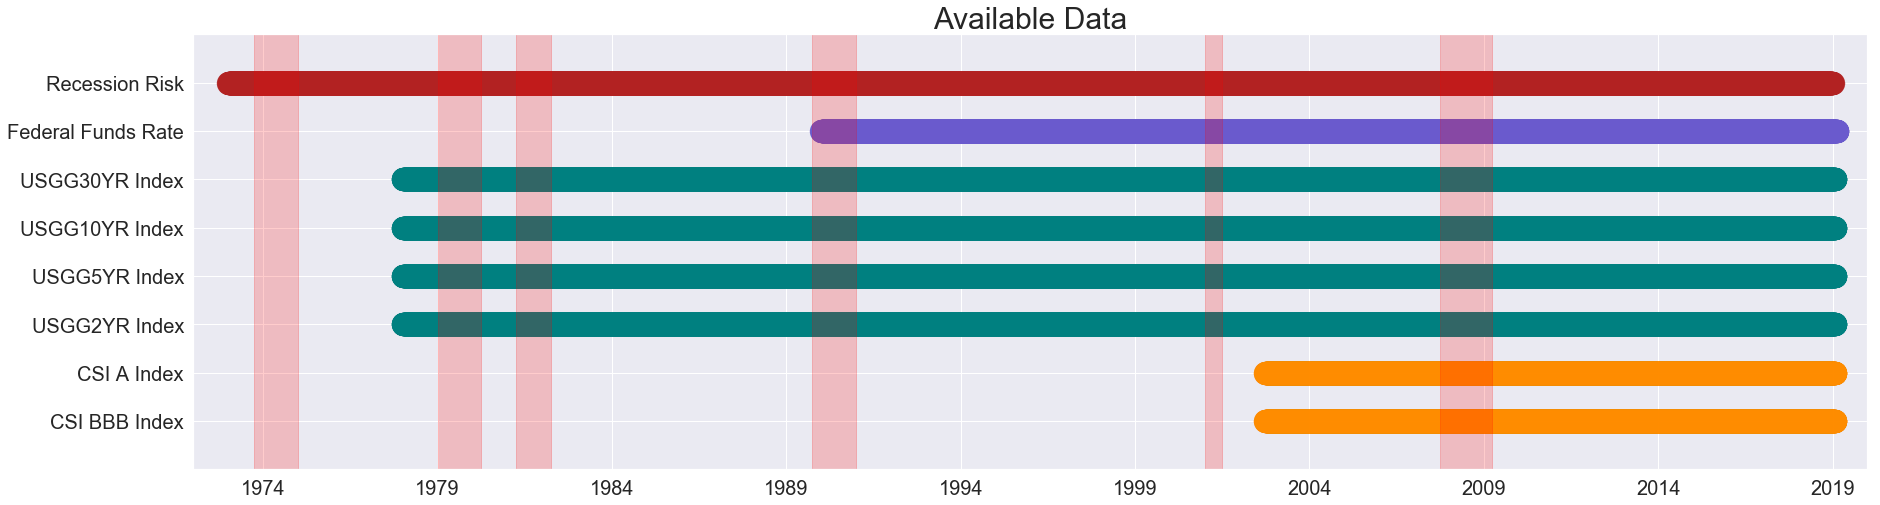

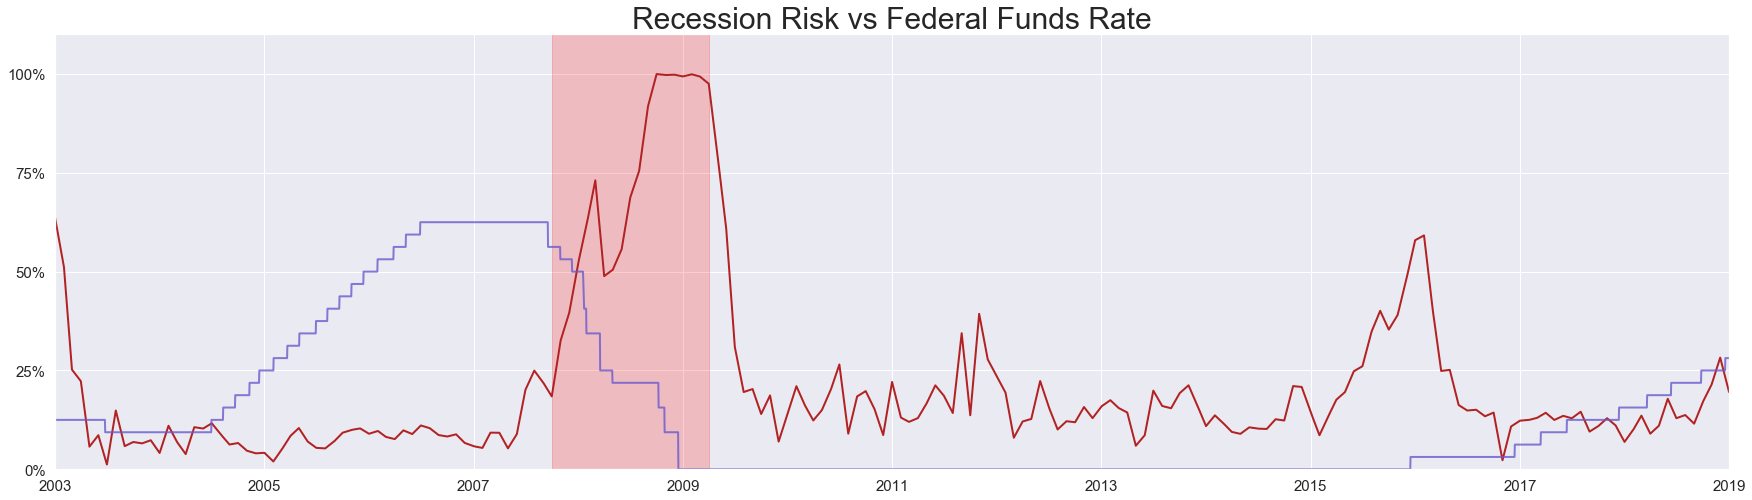

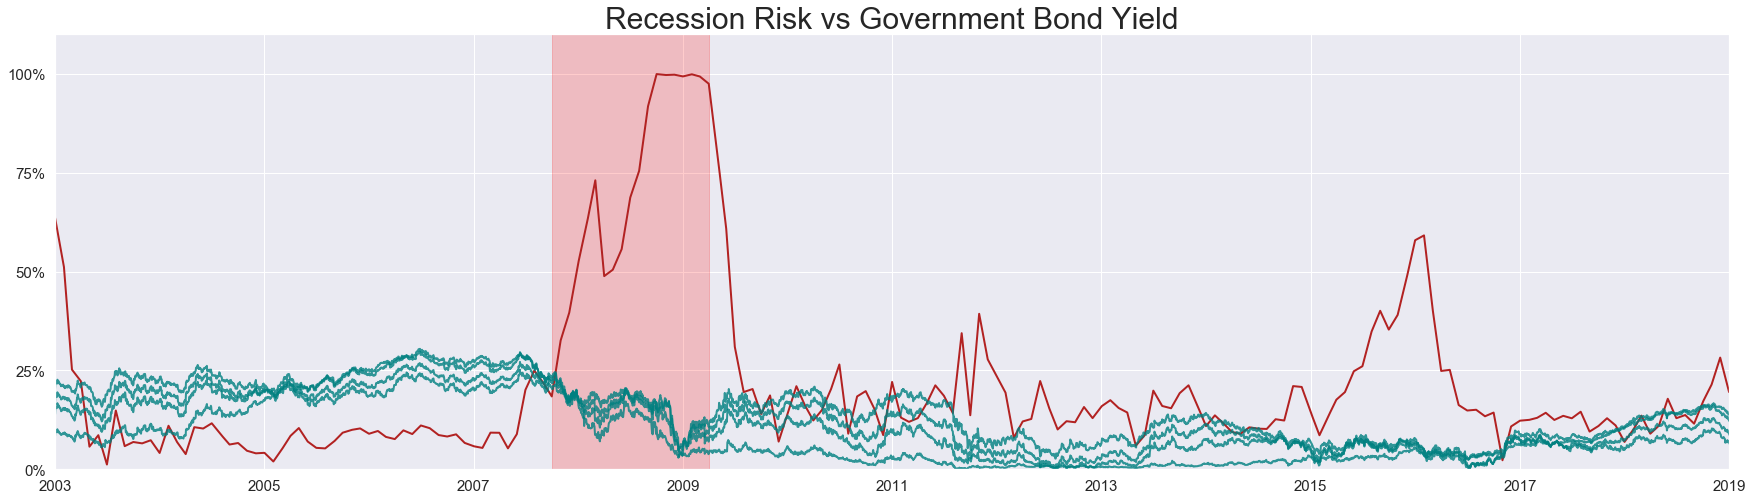

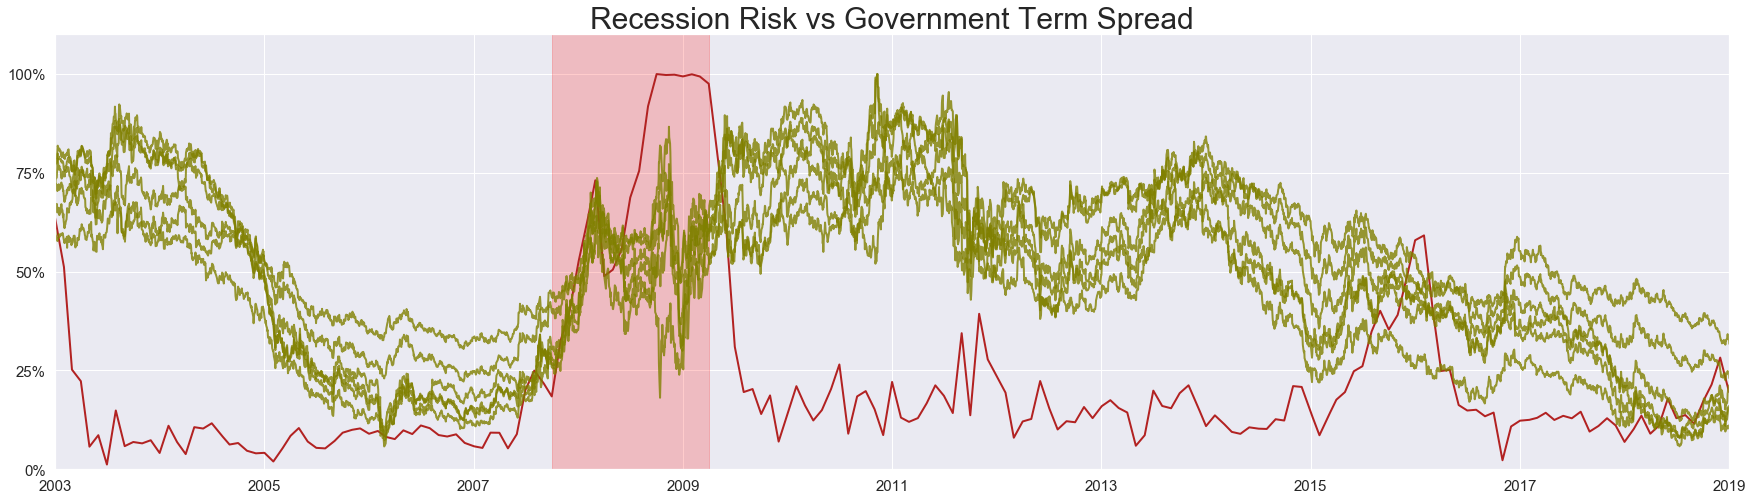

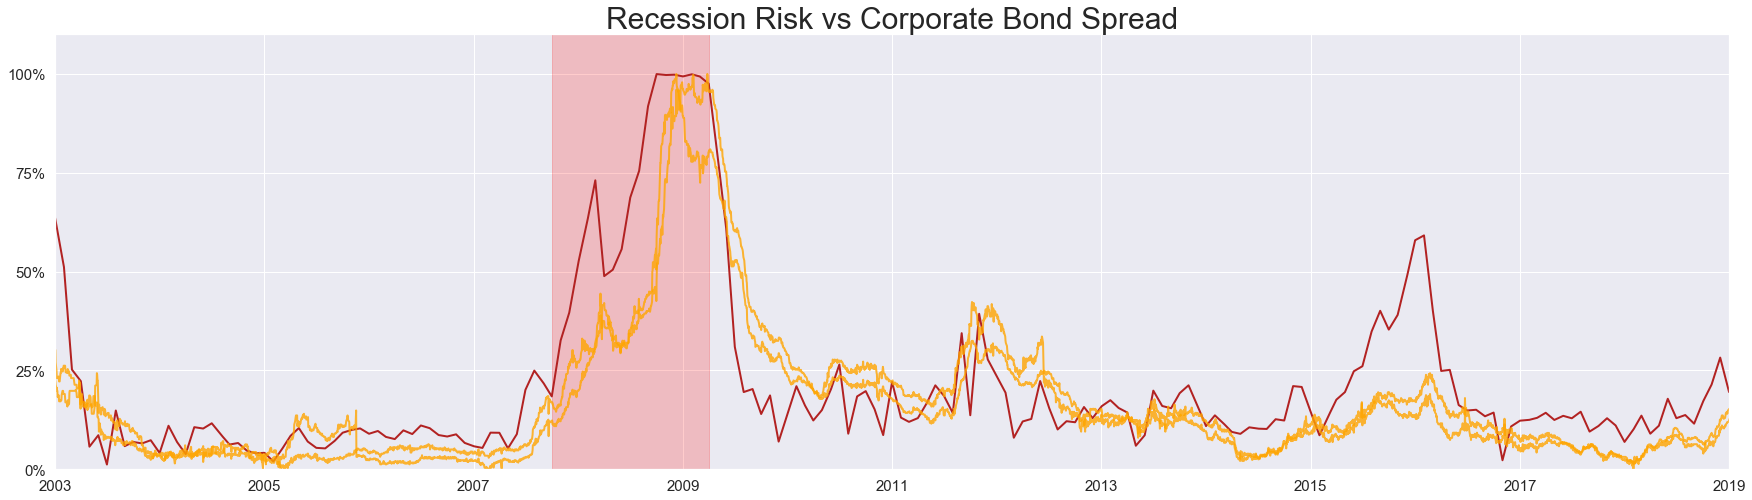

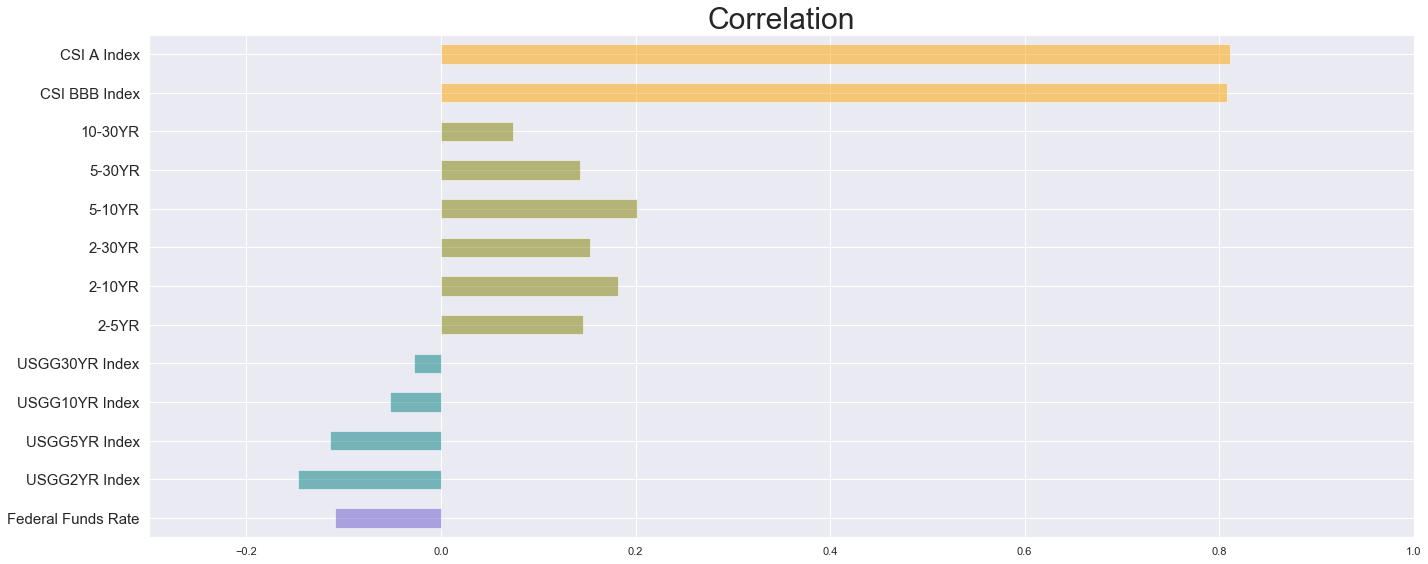

In [27]:
# AVAILABLE DATA
fig, ax = plt.subplots(1,1, figsize=(30, 8))

# Recession risk
plt.scatter(recs_r.iloc[:].dropna().index, [CBS.shape[1]+GBY.shape[1]+RFF.shape[1]]*recs_r.iloc[:].dropna().shape[0], color = 'firebrick', s=500, alpha=0.5)

# US Federal Funds Rate
plt.scatter(RFF.iloc[:].dropna().index, [CBS.shape[1]+GBY.shape[1]]*RFF.iloc[:].dropna().shape[0], color = 'slateblue', s=500, alpha=0.5)

# US government bonds yield
for i in range(0, GBY.shape[1]):
    plt.scatter(GBY.iloc[:,i].dropna().index, [CBS.shape[1]+i]*GBY.iloc[:,i].dropna().shape[0], color = 'teal', s=500, alpha=0.5)

# Corporate bonds
for i in range(0, CBS.shape[1]):
    plt.scatter(CBS.iloc[:,i].dropna().index, [i]*CBS.iloc[:,i].dropna().shape[0], color = 'darkorange', s=500, alpha=0.5)

plot_recs(recs_d, ax)
labels =  CBS.columns.tolist() + GBY.columns.tolist() + RFF.columns.tolist() + ['Recession Risk']
plt.yticks(range(0, CBS.shape[1]+GBY.shape[1]+RFF.shape[1]+1), labels, fontsize=20)
xlim = ['1972', '2020']
ylim = [-1, CBS.shape[1]+GBY.shape[1]+RFF.shape[1]+1]
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(fontsize=20)
plt.title('Available Data', fontsize=30)
#plt.savefig('./plots/b_all_data.png')
plt.show()

# RECESSION RISK VS FEDERAL FUNDS RATE
fig, ax = plt.subplots(figsize=(30,8))
ax.plot(recs_r, linewidth=2, color='firebrick')
ax.plot(RFF, linewidth=2, color='slateblue', alpha=0.8)
plot_recs(recs_d, ax)
ax.set_xlim(['2003', '2019'])
ax.set_ylim([0, 1.1])
plt.xticks(fontsize=15)
plt.yticks(yticks, yticks_label, fontsize=15)
plt.title('Recession Risk vs Federal Funds Rate', fontsize=30)
#plt.savefig('ii_corpb_govtb_prediction.png')
plt.show()


# RECESSION RISK VS GOVERNMENT BONDS YIELD
fig, ax = plt.subplots(figsize=(30,8))
ax.plot(recs_r, linewidth=2, color='firebrick')
ax.plot(GBY, linewidth=2, color='teal', alpha=0.8)
plot_recs(recs_d, ax)
ax.set_xlim(['2003', '2019'])
ax.set_ylim([0, 1.1])
plt.xticks(fontsize=15)
plt.yticks(yticks, yticks_label, fontsize=15)
plt.title('Recession Risk vs Government Bond Yield', fontsize=30)
#plt.savefig('ii_corpb_govtb_prediction.png')
plt.show()


# RECESSION RISK VS GOVERNMENT BONDS TERM SPREAD
fig, ax = plt.subplots(figsize=(30,8))
ax.plot(recs_r, linewidth=2, color='firebrick')
ax.plot(TS, linewidth=2, color='olive', alpha=0.8)
plot_recs(recs_d, ax)
ax.set_xlim(['2003', '2019'])
ax.set_ylim([0, 1.1])
plt.xticks(fontsize=15)
plt.yticks(yticks, yticks_label, fontsize=15)
plt.title('Recession Risk vs Government Term Spread', fontsize=30)
#plt.savefig('ii_corpb_govtb_prediction.png')
plt.show()


# RECESSION RISK VS CORPORATE BONDS SPREAD
fig, ax = plt.subplots(figsize=(30,8))
ax.plot(recs_r, linewidth=2, color='firebrick')
ax.plot(CBS, linewidth=2, color='orange', alpha=0.8)
plot_recs(recs_d, ax)
ax.set_xlim(['2003', '2019'])
ax.set_ylim([0, 1.1])
plt.xticks(fontsize=15)
plt.yticks(yticks, yticks_label, fontsize=15)
plt.title('Recession Risk vs Corporate Bond Spread', fontsize=30)
#plt.savefig('ii_corpb_govtb_prediction.png')
plt.show()


# CORRELATION
corr.iloc[0,1:].plot.barh(color=['slateblue', 'teal', 'teal', 
                                 'teal', 'teal','olive', 'olive', 
                                 'olive', 'olive', 'olive', 'olive',
                                 'orange', 'orange'], alpha=0.5, xlim=(-0.3,1), figsize=(20,8))
plt.yticks(fontsize=15)
plt.title('Correlation', fontsize=30)
#plt.savefig('./plots/e_correlation.png', bbox_inches='tight')
plt.tight_layout()
plt.show()



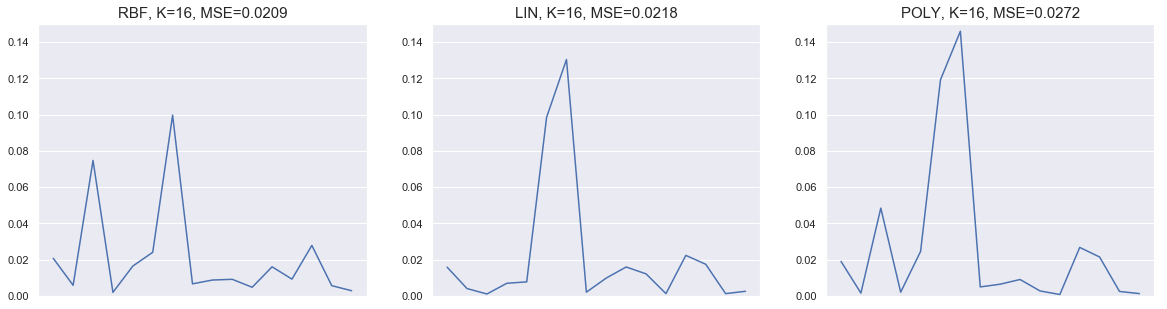

In [44]:
def plot_kfold_mse(mdl):
    fig, ax = plt.subplots(1,len(mdl), figsize=(20,5))    
                       
    for i in range(0,len(mdl)):
        ax[i].plot(mdl[i].mse)
        ax[i].set_title(mdl[i].label + ', K=' + str(k) + ', MSE=' + str(np.mean(mdl[i].mse).round(4)), fontsize=15)
        ax[i].set_ylim(0,0.15)
        ax[i].set_xticks([])

    #plt.savefig('f_stability_daily.png')
    plt.show()

# Use data in this date range 
dates = ['2002-12-31','2018-12-31']
features = all_data.loc[dates[0]:dates[1], 'Federal Funds Rate':]
target = all_data.loc[dates[0]:dates[1], 'Recession Risk']

# k-fold validation
mdl = kfold_validation(16, features, target)
plot_kfold_mse(mdl)


In [59]:
# Recession risk prediction using government bonds yield and corporate bonds using SVN (three kernels) and K-Fold Validation
                      
# Train data
train_dates = ['2002-12-31', '2018-11-30']
train_data = Data(all_data.loc[train_dates[0]:train_dates[1], 'Federal Funds Rate':],
                 all_data.loc[train_dates[0]:train_dates[1], 'Recession Risk'])
    
# Test data
test_dates  = ['2018-11-30', '2019-01-01']
test_data = Data(all_data.loc[test_dates[0]:test_dates[1], 'Federal Funds Rate':],
                 all_data.loc[test_dates[0]:test_dates[1], 'Recession Risk'])

# Initialize models
mdl={}
mdl[0] = Model(1, SVR(kernel='rbf', C=1e3, gamma=0.1), 'RBF')
mdl[1] = Model(1, SVR(kernel='linear', C=1e3), 'LIN')
mdl[2] = Model(1, SVR(kernel='poly', C=1e3, degree=2), 'POLY')

# Train models
mdl = train_svr(mdl, train_data, test_data, 0)
i+=1


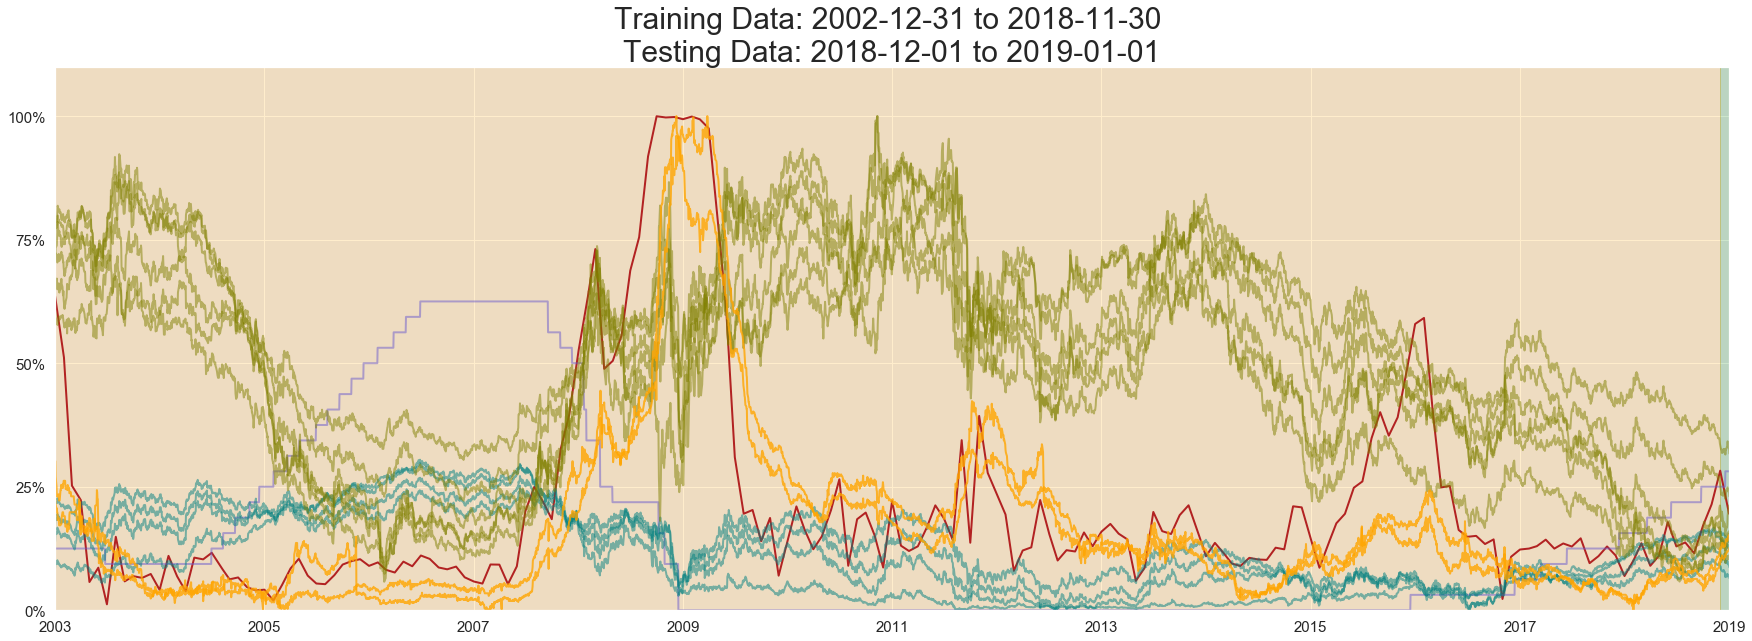

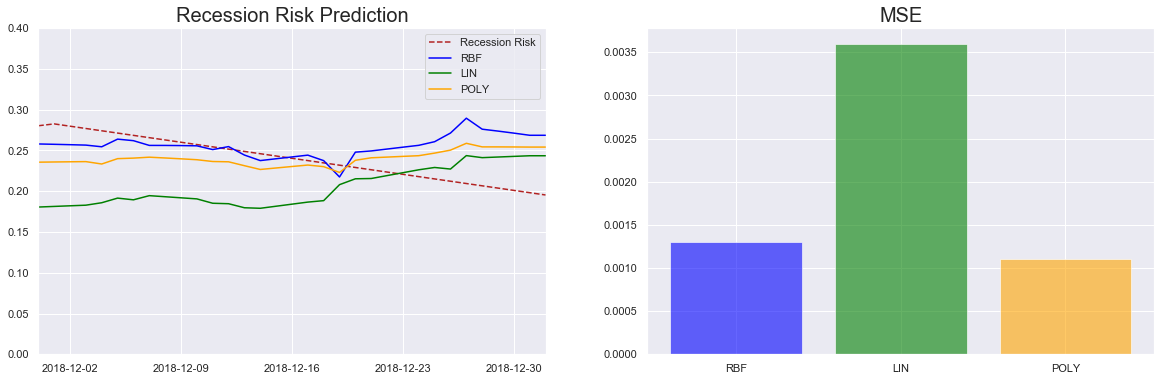

In [76]:
# Recession Risk vs Investment Grade Corporate Bonds
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(recs_r, linewidth=2, color='firebrick')
ax.plot(RFF, linewidth=2, color='slateblue', alpha=0.5)
ax.plot(GBY, linewidth=2, color='teal', alpha=0.5)
ax.plot(TS, linewidth=2, color='olive', alpha=0.5)
ax.plot(CBS, linewidth=2, color='orange', alpha=0.8)

ax.set_xlim(['2003', '2019'])
ax.set_ylim([0, 1.1])
plt.xticks(fontsize=15)
plt.yticks([0, 0.25, 0.50, 0.75, 1], ['0%', '25%', '50%', '75%', '100%'], fontsize=15)
plt.title('Training Data: 2002-12-31 to 2018-11-30 \nTesting Data: 2018-12-01 to 2019-01-01', fontsize=30)

start = mdates.date2num(datetime.strptime(test_dates[0], '%Y-%m-%d'))
end = mdates.date2num(datetime.strptime(test_dates[1], '%Y-%m-%d'))
rect = Rectangle((start, -1), end-start, 20, color='green', alpha=0.2)
ax.add_patch(rect)   

start = mdates.date2num(datetime.strptime(train_dates[0], '%Y-%m-%d'))
end = mdates.date2num(datetime.strptime(train_dates[1], '%Y-%m-%d'))
rect = Rectangle((start, -1), end-start, 20, color='orange', alpha=0.2)
ax.add_patch(rect)   

plt.savefig('ii_corpb_govtb_prediction.png')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(20,6))    

ax[0].plot(recs_r, '--', color='firebrick')
ax[0].plot(mdl[0].pred[0], color='blue')
ax[0].plot(mdl[1].pred[0], color='green')
ax[0].plot(mdl[2].pred[0], color='orange')
ax[0].set_ylim(0,0.4)
ax[0].set_xlim([test_dates[0], test_dates[1]])
ax[0].legend(['Recession Risk', 'RBF', 'LIN', 'POLY'])
ax[0].set_title('Recession Risk Prediction', fontsize=20)

ax[1].bar(1, mdl[0].mse[0], color='blue', alpha=0.6)
ax[1].bar(2, mdl[1].mse[0], color='green', alpha=0.6)
ax[1].bar(3, mdl[2].mse[0], color='orange', alpha=0.6)
plt.xticks((1, 2, 3), ('RBF', 'LIN', 'POLY'))
ax[1].set_title('MSE', fontsize=20)
plt.savefig('i_corpb_govtb_prediction.png')
plt.show()